# Akash Das
## MDS202206
# Assignment_3 : Implement COALS algorithm


# Tasks :
### Implement COALS as mentioned in the paper using the corpus that you had chosen for the first assignment. After building the word vectors,
(a) Identify five (5) nouns and generate five similar words for each noun

(b) Choose a word from step (a) that you believe has a good set of similar words

(c) Select the top 5 similar words. Use cosine distance to find the similarity.

(d) Take the first 200 elements of every word vector selected using step (b)

(e) Normalise them between [0-255]

(f) Use a visualisation as shown below to display their similarity of words along with the cosine
distance score.

### Install and Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import h5py
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import spacy
from gensim.models import Word2Vec
import time
from nltk.tag import tnt
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import os
import re
import string
import random
import pickle
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
import re
import glob
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import time
import scipy as sc
from scipy.sparse.linalg import norm,svds

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#### Mount Google Drive to Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define a function for preprocessing

In [ ]:
def preprocess_text(text_ip):
    text_ip = re.sub(r'http\S+|www\S+|<URL>', '', text_ip)
    text_ip = ''.join(char for char in text_ip if char in string.printable)
    text_ip = re.sub(r'[^a-zA-Z0-9\s\.,!?]', ' ', text_ip)
    text_ip = re.sub(r'(\.|,|\?|!)', r' \1 ', text_ip)
    text_ip = re.sub(r'([/\-])', r' \1 ', text_ip)
    text_ip = re.sub(r'(?<=\S)[%s](?=\S)' % re.escape(string.punctuation), '', text_ip)
    text_ip = re.sub(r'(\w+)-(\w+)', r'\1 \2', text_ip)
    return text_ip

#### Store All Text Files Inside a List

In [ ]:
corpus_files = glob.glob(os.path.join(r"/content/drive/MyDrive/NLP/Eng_Data/wiki", '*.txt'))

In [ ]:
corpus_files_2=corpus_files[:30]

### Preprocess the using the function defined above files and saving those cleaned files in drive

In [ ]:
cleaned_folder_path="/content/drive/MyDrive/NLP/cleaned_wiki"

for file_name in corpus_files_2:
  with open(file_name, 'r', encoding='utf-8') as file:
    corpus = file.read().lower()

  cleaned_corpus=preprocess_text(corpus)

  output_file_path=os.path.join(cleaned_folder_path,file_name[-11:])
  with open(output_file_path, 'w') as output_file:
    output_file.write(cleaned_corpus)
print("Cleaning Completed")

Cleaning Completed


### Calculate vocabulary size

In [ ]:
vocabulary = set()
cleaned_folder_path="/content/drive/MyDrive/NLP/cleaned_wiki_2"
corpus_files = os.listdir(cleaned_folder_path)
for file_name in corpus_files:
  file_path = os.path.join(cleaned_folder_path, file_name)
  with open(file_path, 'r') as file:
        for sent in file.readlines():
            vocabulary.update(set(sent.split()))

In [ ]:
vocab_index = { word:index for index,word in enumerate(vocabulary)  }
index_vocab = { index:word for index,word in enumerate(vocabulary)  }
vocabulary_size = len(vocabulary)
print(f'Length of the vocabulary is {vocabulary_size}')

Length of the vocabulary is 506984


## creating a sparse co-occurance matrix of size (vocab_size  x  vocab_size)

In [ ]:
co_occurance_matrix = sc.sparse.lil_matrix( (vocabulary_size, vocabulary_size), dtype=np.int32 )
lines_skipped = 0
vocab_count = {}
cleaned_folder_path="/content/drive/MyDrive/NLP/cleaned_wiki_2"
corpus_files = os.listdir(cleaned_folder_path)
for file_name in corpus_files:
  file_path = os.path.join(cleaned_folder_path, file_name)
  with open(file_path, 'r') as f:
        for i in f.readlines():
            i = i.split()
            for j in i:
                if j in vocab_count:
                    vocab_count[j]+=1
                else:
                    vocab_count[j]=1
            if len(i) <=4:
                lines_skipped+=1
                continue
            for j in range(len(i)-4):
                phrase = i[j:j+5]
                w1,w2,w3,w4,w5 = phrase[0],phrase[1],phrase[2],phrase[3],phrase[4]
                co_occurance_matrix[ vocab_index[w2],vocab_index[w1] ] += 4
                co_occurance_matrix[ vocab_index[w3],vocab_index[w1] ] += 3
                co_occurance_matrix[ vocab_index[w4],vocab_index[w1] ] += 2
                co_occurance_matrix[ vocab_index[w5],vocab_index[w1] ] += 1
                co_occurance_matrix[ vocab_index[w5],vocab_index[w4] ] += 4
                co_occurance_matrix[ vocab_index[w5],vocab_index[w3] ] += 3
                co_occurance_matrix[ vocab_index[w5],vocab_index[w2] ] += 2
                co_occurance_matrix[ vocab_index[w5],vocab_index[w1] ] += 1
  print(f'{f} Done')

<_io.TextIOWrapper name='/content/drive/MyDrive/NLP/cleaned_wiki_2/wiki_ek.txt' mode='r' encoding='UTF-8'> Done
<_io.TextIOWrapper name='/content/drive/MyDrive/NLP/cleaned_wiki_2/wiki_ad.txt' mode='r' encoding='UTF-8'> Done
<_io.TextIOWrapper name='/content/drive/MyDrive/NLP/cleaned_wiki_2/wiki_bo.txt' mode='r' encoding='UTF-8'> Done
<_io.TextIOWrapper name='/content/drive/MyDrive/NLP/cleaned_wiki_2/wiki_cf.txt' mode='r' encoding='UTF-8'> Done
<_io.TextIOWrapper name='/content/drive/MyDrive/NLP/cleaned_wiki_2/wiki_fj.txt' mode='r' encoding='UTF-8'> Done
<_io.TextIOWrapper name='/content/drive/MyDrive/NLP/cleaned_wiki_2/wiki_fl.txt' mode='r' encoding='UTF-8'> Done
<_io.TextIOWrapper name='/content/drive/MyDrive/NLP/cleaned_wiki_2/wiki_es.txt' mode='r' encoding='UTF-8'> Done
<_io.TextIOWrapper name='/content/drive/MyDrive/NLP/cleaned_wiki_2/wiki_dj.txt' mode='r' encoding='UTF-8'> Done
<_io.TextIOWrapper name='/content/drive/MyDrive/NLP/cleaned_wiki_2/wiki_ax.txt' mode='r' encoding='UTF-8

In [ ]:
print( f' The shape of the co-occurence matrix is {co_occurance_matrix.shape}' )

 The shape of the co-occurence matrix is (506984, 506984)


## Extracting the 15000 most frequently used words

In [ ]:
sorted_vocab =  dict(sorted(vocab_count.items(), key=lambda item: item[1],reverse=True)[:15000])
index_list = [ vocab_index[key] for key in sorted_vocab.keys()  ]
co_occurance_matrix_reduced = co_occurance_matrix.tocsc()[:,index_list]

In [ ]:
print( f' The shape of the co-occurence matrix is {co_occurance_matrix_reduced.shape}' )

 The shape of the co-occurence matrix is (506984, 15000)


Save the co-occurence matrix in drive for later use

In [ ]:
with open('/content/drive/MyDrive/NLP/co-occurence_matrix_30.pkl', 'wb') as fp:
    pickle.dump(co_occurance_matrix_reduced, fp)

In [ ]:
total_sum = co_occurance_matrix_reduced.sum()
row_sum = np.array(co_occurance_matrix_reduced.sum(axis=1)).flatten()
col_sum = np.array(co_occurance_matrix_reduced.sum(axis=0))[0]

### Calculate co-occurence correlations

In [ ]:
co_occurance_correlation = sc.sparse.lil_matrix(co_occurance_matrix_reduced.shape,dtype=np.float32)
row,col = co_occurance_matrix_reduced.nonzero()
for i,j in zip( row,col ):
    v = co_occurance_matrix_reduced[i,j]
    value = ((int(v)*int(total_sum)) - (int(row_sum[i])*int(col_sum[j])))/(np.sqrt( row_sum[i])*np.sqrt(total_sum-row_sum[i])*np.sqrt(col_sum[j])*np.sqrt(total_sum-col_sum[j]))
    if value > 0:
        co_occurance_correlation[i,j] = np.sqrt(value)


Save the co-occurence correlation matrix in drive for later use

In [ ]:
with open('/content/drive/MyDrive/NLP/co-occurence_correlations_30.pkl', 'wb') as fp:
    pickle.dump(co_occurance_correlation, fp)

In [ ]:
co_occurance_correlation_csr = co_occurance_correlation.tocsr()
left_singular,singulars,right_singular = svds(co_occurance_correlation_csr,k=1000)

In [ ]:
svd = (co_occurance_correlation_csr@right_singular.T)

Save the co-occurence SVD in drive for later use

In [ ]:
with open('/content/drive/MyDrive/NLP/co_occur_svd_30.pkl', 'wb') as fp:
    pickle.dump(svd, fp)

In [ ]:
svd.shape

(506984, 1000)

### Define a function to get similar words of a given word

In [ ]:
def similar_words(index,embedding_len = 50):
    word_vector = svd[index]
    word_vector_norm = np.linalg.norm(word_vector)
    correl = []

    for row in range(svd.shape[0]):
        vector = svd[row]
        if np.all(svd[row]==0):
            correl.append(0)
            continue
        vector_norm = np.linalg.norm(vector)
        correl.append(  np.multiply(vector,word_vector ).sum() / (word_vector_norm*vector_norm)   )
    max_5 = sorted(correl,reverse=True)[1:6]
    indexes = [ correl.index(value) for value in max_5 ]
    sim_words = [ index_vocab[ind] for ind in indexes ]
    print(f'Similar words are {sim_words}')

    word_embeddings = np.array([ svd[ind][:embedding_len]*255 for ind in [index]+indexes])
    return sim_words,word_embeddings


#### We have to identify five (5) nouns and generate five similar words for each noun

In [ ]:
noun_words=['laptop','school','apple','chicken','orange']

In [ ]:
for i in noun_words:
  print("The given word is "+i)
  sim_words=similar_words( vocab_index[i] )



The given word is laptop
Similar words are ['computers', 'hardware', 'desktop', 'plug', 'unix']
The given word is school
Similar words are ['high', 'schools', 'college', 'elementary', 'secondary']
The given word is apple
Similar words are ['microsoft', 'ibm', 'mobile', 'macintosh', 'desktop']
The given word is chicken
Similar words are ['pork', 'meat', 'tuturuga', 'beef', 'wontons']
The given word is orange
Similar words are ['red', 'yellow', 'purple', 'color', 'blue']


### Visualize the similarity of words along with the cosine distance score

The given word is laptop
Similar words are ['computers', 'hardware', 'desktop', 'plug', 'unix']


<Figure size 640x480 with 0 Axes>

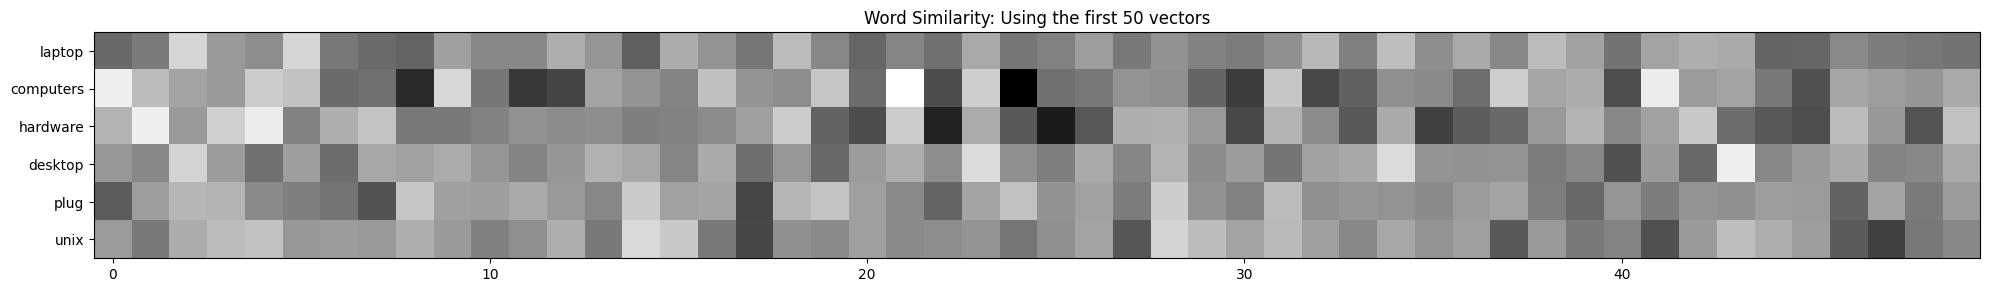

The given word is school
Similar words are ['high', 'schools', 'college', 'elementary', 'secondary']


<Figure size 640x480 with 0 Axes>

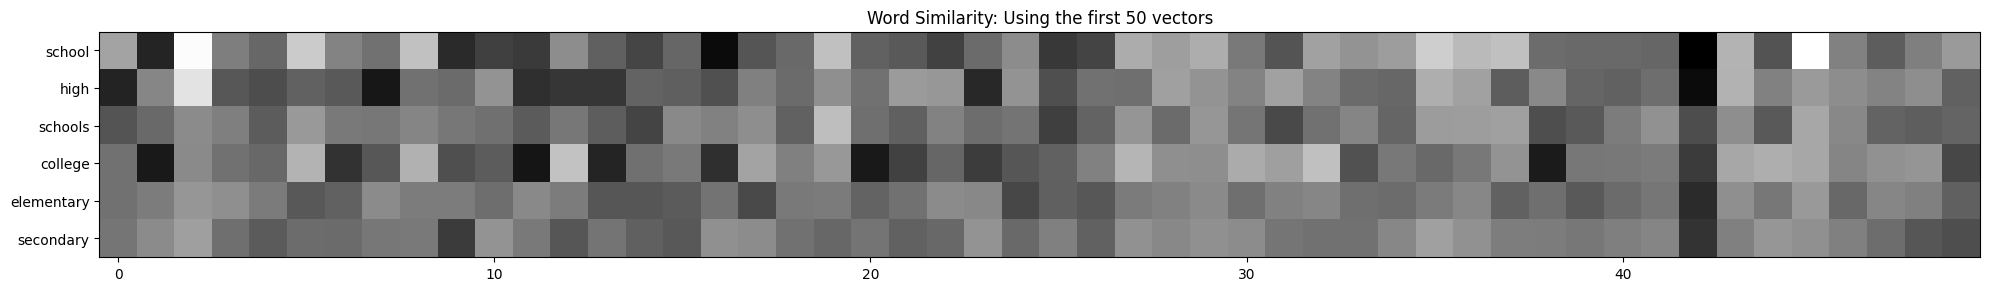

The given word is apple
Similar words are ['microsoft', 'ibm', 'mobile', 'macintosh', 'desktop']


<Figure size 640x480 with 0 Axes>

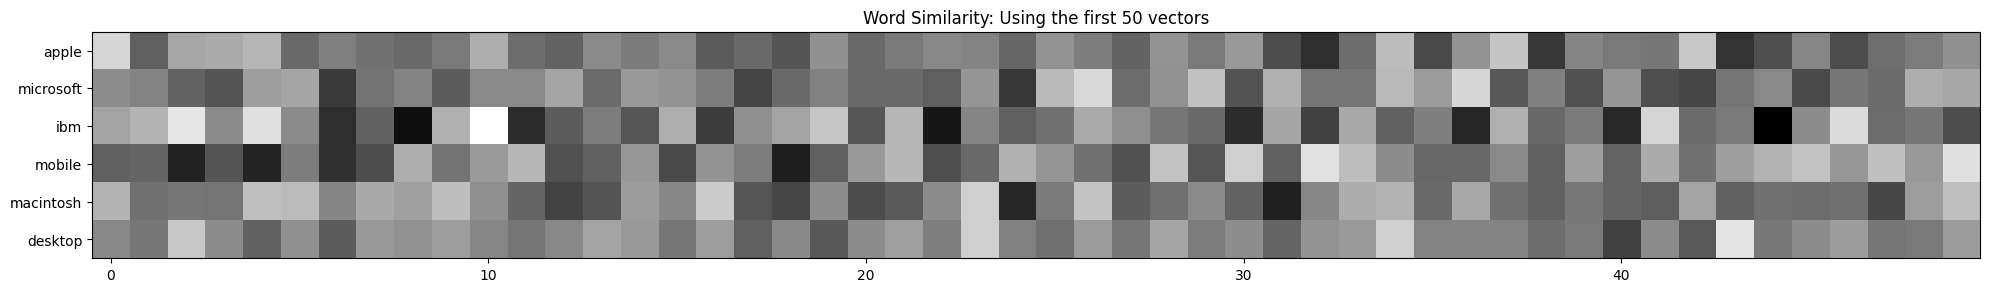

The given word is chicken
Similar words are ['pork', 'meat', 'tuturuga', 'beef', 'wontons']


<Figure size 640x480 with 0 Axes>

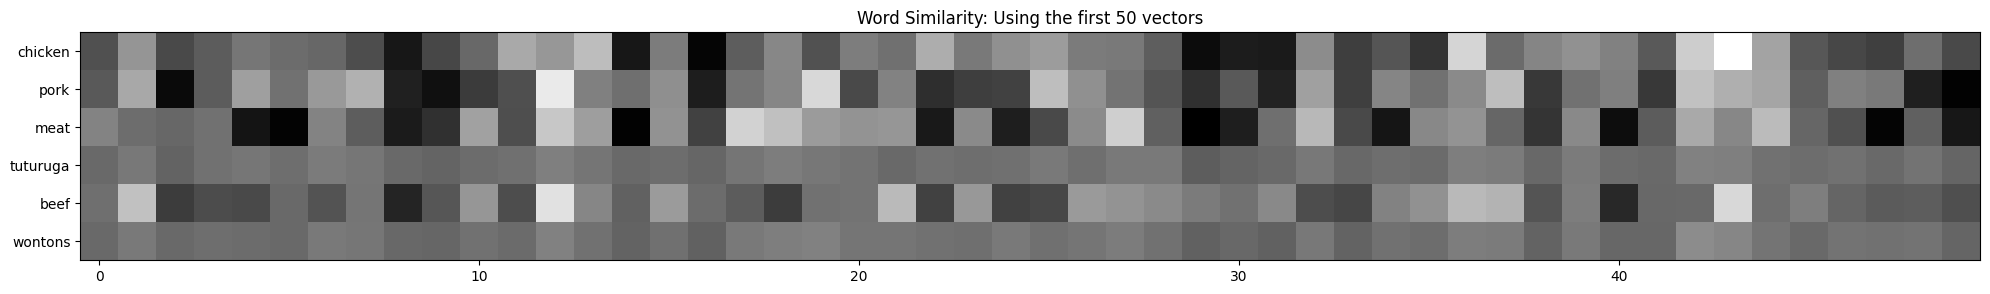

The given word is orange
Similar words are ['red', 'yellow', 'purple', 'color', 'blue']


<Figure size 640x480 with 0 Axes>

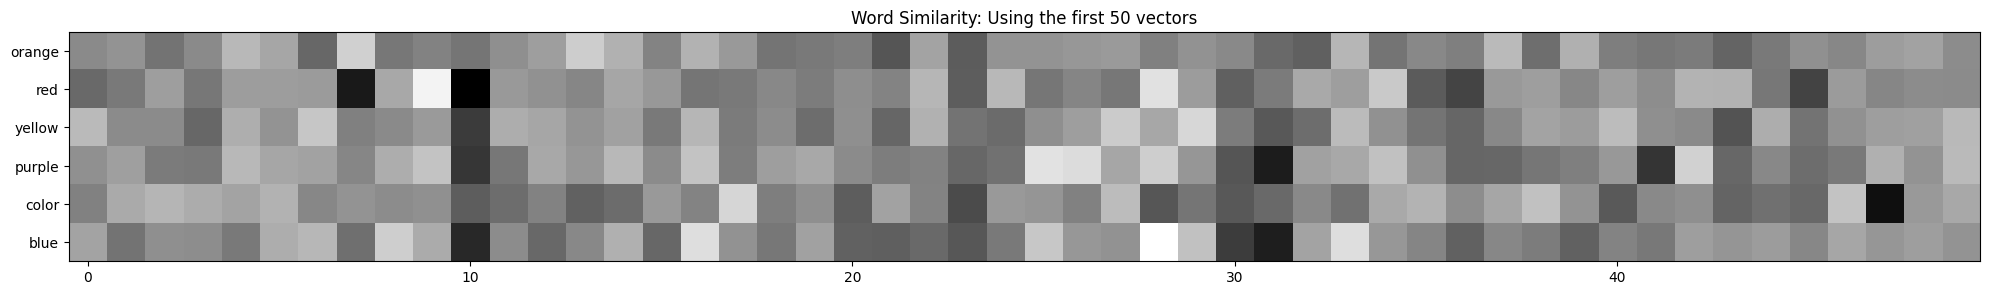

In [ ]:
for i in noun_words:
  input_word=i
  print("The given word is "+i)
  similar_words_output,word_embeddings = similar_words( vocab_index[input_word] )
  plt.set_cmap('gray')
  plt.figure(figsize=(20,40))
  plt.imshow(word_embeddings)

  plt.yticks(np.arange(len([input_word]+similar_words_output)),[input_word]+similar_words_output)
  plt.title("Word Similarity: Using the first 50 vectors")
  plt.tight_layout()
  plt.show()

In [ ]:
for i in ['apples','apple']:  ### The function treats 'apples' as collection of fruits and 'apple' as a company name
  print("The given word is "+i)
  sim_words=similar_words( vocab_index[i] )



The given word is apples
Similar words are ['tomatoes', 'potatoes', 'barley', 'tea', 'bananas']
The given word is apple
Similar words are ['microsoft', 'ibm', 'mobile', 'macintosh', 'desktop']
